# 1 - Data acquisition

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
data = pd.read_csv("bci05.csv")
data.head()

,tag,sp,gx,gy,dbh,pom,date,codes,status
0,105951,ACACME,610.0,104.7,119.0,1,8924.0,M,A
1,132160,ACACME,534.8,241.3,116.0,1,8922.0,*,A
2,132234,ACACME,539.4,242.3,NaN,0,8922.0,DN,D
3,132235,ACACME,538.8,242.5,NaN,0,8922.0,DN,D
4,191542,ACACME,282.7,177.5,75.0,1,8825.0,*,A


In [3]:
data = data[data["status"]=='A'][["tag", "sp", "gx", "gy"]]

In [4]:
# 1) Species spotting
types = data['sp'].value_counts().keys() 
S = len(types)
print("There are {} different species".format(S))

There are 299 different species


# 2 - Statistics on subplots

Now we divide the total area of study (sampled plot) in 200 subplots of the same area.
To do so we add two columns to the dataset, called $i$ and $j$, that are the result of division without rest respectively of $gx$ and $gy$ for 50 (0.5 hectars in each axis). Then we use some methods of pandas to encode in a 3D matrix the aboundance $x_k$ of each of the S species for each subplot $(i,j)$ and from that we can obtain the average presence of each species.

In [5]:
# 2) Subsampling
# 50 * 50 meters
data["i"], data["j"] = data["gx"]//50, data["gy"]//50
# a)
cell_pop = data.groupby(["i", "j"])["sp"].value_counts()
# b) shaping them in a matrix
cell_pop_M = cell_pop.unstack().stack(dropna = False).fillna(0).astype(int)
cell_pop_M = np.array(cell_pop_M).reshape(20, 10, 299) # (i, j, specie)


# this prints are just for understanding how to work with this dataset
#print("Presence and aboundance in subplot (0,0) : \n", cell_pop_M[0,0,:], '\n')
#print("Aboundances of the various species: \n", cell_pop_M.sum(axis=(0,1)), '\n')

p_i = np.count_nonzero(cell_pop_M, axis = (0,1))/200
#print("Absolute presence for each species: \n", presence, '\n')
#print("Relative presence for each species: \n", p_i, '\n')

And the average squared difference between present and absent species in a subplot (that will be used as a constraint in section 4):

In [6]:
def pairing_p(configs):
    # In each subplot there are more absent species than present (just an observation)
    # S+ - S-
    S_present = np.count_nonzero(configs, axis = (1)).flatten()
    # S_absent = S - S_present -> S_pm = 2*S_present - S
    S_pm = 2*S_present - S # Broadcasting
    # constraint C_0 = < (S+ - S-)^2 >
    return np.mean(np.power(S_pm,2))


C_0_over_S = pairing_p(cell_pop_M.reshape(200, 299))/299
print(C_0_over_S)

21.32829431438127


## 3 - Max Ent 1

### Hamiltonian of the system for our constraints.

We start considering a generic entropy:

$$ S[\{p_a\}_{i=1,\ldots,n}] = -K \sum_{a=1}^n p_a ln(p_a), K > 0$$

and following constraints:

$$ \sum_{a=1}^n p_a - 1 = 0 $$

$$\sum_{a=1}^n  p_a f_r(x_a) - <f_r(x)>_{obs} = 0 $$

On the PDF we show that the corresponding Hamiltonian is:

$$H(x_a, \vec{\lambda}) = - \sum_{r=1}^{m}\lambda_i f_i(x_a)$$


### Analytical derivation of the tuned Lagrangian multipliers as functions of the constraints.

Adopting the notation to our specific model, we set $K=1$, and rename:

$x_a \rightarrow \vec{\sigma^{(a)}}, m \rightarrow S, f_r(x) \rightarrow \pi_i(\vec{\sigma}) = \sigma_i$

We start considering the following Hamiltonian:

$H(\vec{\sigma}, \vec{\lambda}) = - \sum_{i=1}^{S}\lambda_i f_i(\sigma) = - \sum_{i=1}^{S}\lambda_i \sigma_i $

Manipulating the partition function

$$Z(\vec{\lambda}) = \sum_{\{\vec{\sigma}\}} \exp\{\sum_{i=1}^S \lambda_i \sigma_i\} = \
    \sum_{\{\vec{\sigma}\}} \prod_{i=1}^S\exp\{\lambda_i \sigma_i\} = \
    \prod_{i=1}^S \sum_{\sigma_i = \pm 1} \exp\{\lambda_i \sigma_i\}  = \
    2^S \prod_{i=1}^S \cosh(\lambda_i)$$

Hence we can compute analytically the expected value for each variable $\sigma_i$ for a given value of $\vec{\lambda}$

$$ <\sigma_i>_{model(\vec{\lambda})} = \sum_{\{\vec{\sigma}\}} \sigma_i P(\vec{\sigma}/\vec{\lambda}) = \
\frac{\sum_{\sigma_i \pm 1} \sigma_i e^{\lambda_i \sigma_i}}{2 cosh(\lambda_i)} = tanh(\lambda_i) $$

Now we impose $\forall i$ $m_i = <\sigma_i>_{model(\vec{\lambda})}$ 

$m_i = tanh(\lambda_i) $

and inverting the system we find

$ \lambda_i = tanh^{-1}(m_i) = \frac{1}{2} \cdot ln(\frac{1 + m_i}{1 - m_i} )$

Here we apply the formula just obtained to compute the lagrangian parameters for the model Max Ent 1

In [7]:
m_i = 2*p_i - 1
print(m_i.max(), m_i.min())
# PROBLEM: too much variance depending on epsilon...
eps = 0
l_i = np.arctanh(m_i- np.sign(m_i)*eps) # same function
print(l_i.max(),l_i.min())

1.0 -0.99
inf -2.6466524123622457


/home/nicola/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in arctanh
  """


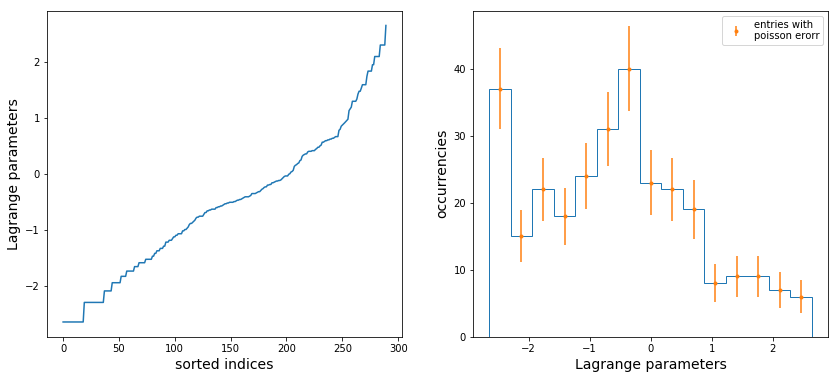

In [8]:
# first we remove from the plots the infinite eigenvalues
l_i_sorted = l_i[np.isfinite(l_i)]
# then we sort the remaining one for the first plot
l_i_sorted.sort()

fig, ax = plt.subplots(ncols=2, figsize=(14, 6))
# left panel
ax[0].plot(l_i_sorted)
ax[0].set_xlabel("sorted indices", fontsize = 14)
ax[0].set_ylabel("Lagrange parameters", fontsize = 14)
# right panel
counts, bin_extremes1, _ = ax[1].hist(l_i_sorted, bins = 15, histtype = 'step', density = False)
bin_centers1 = (bin_extremes1[1:] + bin_extremes1[:-1])/2
ax[1].errorbar(bin_centers1, counts, np.sqrt(counts), fmt = '.', label = 'entries with \npoisson erorr')
ax[1].set_xlabel("Lagrange parameters", fontsize = 14)
ax[1].set_ylabel("occurrencies", fontsize = 14)
plt.legend()
plt.show()

## Theoric estimate of the parameters

$$M = \sum_i \sigma_i $$
$$Var(M)_{obs} = <M^2>_{obs} - <M>_{obs}^2$$

$$K = -\frac{1}{2}\frac{S}{Var(M)_{obs}} \\ \lambda_i = tanh^{-1}(m_i) + \frac{<M>_{obs}}{Var(M)_{obs}}$$

In [10]:
# array of abundances for each subplot
cell_pop_M = np.array(cell_pop_M).reshape(200, 299)
# for each subplot is True if a species is present, False otherwise
cell_presence_mask = cell_pop_M > 0
# True -> 1, False -> 0
cell_presence = cell_presence_mask.astype(int)
# True -> +1, False -> -1 (spins)
cell_spins = cell_presence*2 -1
# total magnetization for each subplot/configuration
cell_M = cell_spins.sum(axis = 1)
# total magnetization averaged over the observed configurations
M = cell_M.mean()
print("Average magnetization: ", M)
# squared magnetization averaged over the observed configurations
M2 = np.power(cell_M,2).mean()
print("Average squared magnetization: ", M2)
# variance of the total magnetization
Var_M = M2 - M**2
print("Var M ", Var_M)
# equivalently
print("Var M (second method) ", cell_M.var())
# lagrange parameter K
K = 0.5*S/Var_M
print("K : ", K)
eps = 10**-6
# negative shift of M/Var_M
sp_l_i = np.arctanh(m_i - np.sign(m_i)*eps) + M/Var_M
print("Max and min lambda" ,sp_l_i.max(), sp_l_i.min())


Average magnetization:  -77.13
Average squared magnetization:  6377.16
Var M  428.1231000000007
Var M (second method)  428.12309999999997
K :  0.3491986300201969
Max and min lambda 7.074170155478721 -2.8267606273746813


## 4 - Max Ent 2

Now we consider a new Hamiltonian

$H(\vec{\sigma}, \vec{\lambda}, K) = - \frac{K}{S}\sum_{i,j}\sigma_i\sigma_j - \sum_{i=1}^{S}\lambda_i \sigma_i$



### Constraints for Max Ent 2

The constraints that we are going to use are:
* $m_i = <\sigma_i>_{model} = C_i(\vec{\sigma}) $ with coupled parameters $\lambda_i, i = 1,\ldots, S$
* $\frac{<(S_+ - S_-)^2>_{exp}}{S} = \frac{<(\sum_{j=1}^{S}\sigma_j)^2>_{model}}{S} = \frac{C_0(\vec{\sigma})}{S}$ with coupled parameter $\lambda_0 = K$

To initialize the Lagrange multipliers we have two possible choices: extracting them from a gaussian distribution centered in 0 or to take the initial $\lambda_i$ as the one of the previous point and for $K'$ using a gaussian with variance that is a funtion of S. [WORK IN PROGRESS]

### Gradient descent function

The objective function that we want to minimize is the Kullback–Leibler divergence $D_{KL}(P_{exp}/P_{model})$.

The derivatives of the KL-divergence w.r.t. the Lagrangian multipliers are:

$$ \frac{\partial D_{KL}}{\partial \lambda_a} = <C_a(\vec{\sigma})>_{model}-<C_a(\vec{\sigma})>_{exp} $$

More in concrete:

$$\frac{\partial D_{KL}(t)}{\partial \lambda_0} = \frac{<(\sum_{j=1}^{S}\sigma_j)^2>_{model(t)}}{S} - \frac{<(S_+ - S_-)^2>_{exp}}{S}  $$

$$\frac{\partial D_{KL}(t)}{\partial \lambda_i} = <\sigma_i>_{model(t)} - m_i $$


Thus the update rule for gradient descent will be:

$$\lambda_a(t+1) \leftarrow \lambda_a(t) - \eta \cdot \frac{\partial D_{KL}(t)}{\partial \lambda_a}$$


### Stopping criteria
Then we want to run the cycle of Metropolis and gradient descent until a stopping criteria is met.
Possible choices are:
* fixed number of iterations
* margin of improvement under a certain threshold

In [26]:
def gradient(model_configs, exp_constraints):
    update1 = pairing_vec(model_configs) - exp_constraints[0]
    print("Model constraint C_0: ", pairing_vec(model_configs))
    print("Observed constraint C_0: ", exp_constraints[0])
    update2 = model_m(model_configs) - exp_constraints[1:]
    
    #update2 = model_m(model_configs) - exp_constraints    
    gradient = np.concatenate((update1[np.newaxis], update2))
    return gradient

# provare a diminuire beta1 = 0.9 di default
def adam(grad, m, s, beta1=0.9, beta2=0.99, e=1e-8):
    # m = momentum = 0.9 last_m + 0.1 new_gradient
    m = beta1*m+(1-beta1)*grad
    # s = second moment = 0.99 last_s + 0.01 new_gradient**2 (elementwise?)
    s = beta2*s+(1-beta2)*(grad**2)
    m_c = m/(1-beta1)
    s_c = s/(1-beta2)
    # return new_m, new_s and adam_gradient
    return m, s, (m_c/np.sqrt(s_c+e))

In [21]:
def pairing(configs):
    return np.power(configs.sum(),2)/S

def pairing_vec(configs):
    #print("Configs shape (n,S): ", configs.shape)
    Spm = configs.sum(axis=1)
    #print("Summing over i for each config: (n)", Spm.shape)
    mean_Spm = Spm.mean()
    return np.power(mean_Spm,2)/S

def model_m(configs):
    # assuming configs have a shape of (n, S) with S = 299
    return configs.mean(axis=0)


def compute_energy(config, L_multipliers):
    """Computes the energy of a configuration."""
    model_pair = pairing(config) # C_0/S
    #model_m_i = model_m(configs)
    model_parameters = np.concatenate((model_pair[np.newaxis], config))
    # L_multipliers[0] = K
    return -np.dot(model_parameters[1:], L_multipliers[1:]) - model_parameters[0]*L_multipliers[0]


In [22]:
def METRO(lagrange_multipliers, M=1e4, N=1000):
    configs = []
    configuration = np.random.choice([+1,-1], size = 299)
    Spm = configuration.sum()
    flip_spins = np.random.randint(low = 0, high = 299, size = int(M))
    for index in flip_spins:
        new = np.copy(configuration) # !!!!!!!
        new[index] = -configuration[index] # !!!!!!!
        #print(new[index], configuration[index]) flipping works
        if acceptance(configuration, lagrange_multipliers, index, Spm): 
            Spm = Spm -2*configuration[index]
            configuration = new
            configs.append(configuration)    
             
    return np.array(configs[-N:])

def acceptance(old, lagrange_multipliers, flipped_index, Spm):
    """Implements Metropolis choice."""
    # regularizer?
    #en1 = compute_energy(new, lagrange_multipliers)
    #en2 = compute_energy(old, lagrange_multipliers)
    dE = compute_dE(old, lagrange_multipliers, flipped_index, Spm)
    #print("Delta E, old method: ", en1-en2)
    #print("Delta E, new method: ", dE)
    if  dE < 0:
        #print("New energy: ", en1) - high and always negative, but seems to work
        return True
    else:
        P = np.random.random()
        if P < np.exp(-dE): #in teoria no <------------------- BETA?
            #print("New energy: ", en1) -  high and always negative, but seems to work
            return True
        else:
            return False
        
def compute_dE(old, lagrange_multipliers, flipped_index, Spm):
    first_term = 4*lagrange_multipliers[0]/S*(old[flipped_index]*Spm -1)
    second_term = 2*lagrange_multipliers[flipped_index+1]*old[flipped_index]
    return  first_term + second_term
    


In [23]:
# Hyperparameters

# and the number of iterations
max_iter = 1000

#suppression = np.arange(1,max_iter+1)
# the learning rate
eta = 0.1

#lagrange_multipliers = np.concatenate((np.array([K]), sp_l_i))
lagrange_multipliers = np.random.randn(300)
print("Theorical K: ", K)
exp_constraints = np.concatenate((C_0_over_S[np.newaxis], m_i))
print(lagrange_multipliers[0]*exp_constraints[0])
mean_sq_loss = np.zeros(max_iter) # gradient square sum
Ks = np.zeros(max_iter)
m = 0; s=0
#last_config = np.random.choice([+1,-1], size = 299)

from tqdm import tnrange
for i in tnrange(max_iter):
    #configs = METRO(lagrange_multipliers, last_config)
    configs = METRO(lagrange_multipliers)
    #last_config = configs[-1]
    g = gradient(configs, exp_constraints)
    print("First component of g:", g[0])
    m, s, update = adam(g, m, s)
    print("First component of adams:", update[0])
    lagrange_multipliers = lagrange_multipliers - eta*update
    Ks[i] = lagrange_multipliers[0]
    print("K : ", Ks[i])
    mean_sq_loss[i] = np.power(g,2).sum()
    print("Squared gradient: ", mean_sq_loss[i])
    #break

Theorical K:  0.3491986300201969
6.442660640641161


Model constraint C_0:  0.0966601204013378
Observed constraint C_0:  21.32829431438127
First component of g: -21.231634193979932
First component of adams: -0.9999999999889081
K :  0.4020710679275153
Squared gradient:  779.4914145469777
Model constraint C_0:  0.128561872909699
Observed constraint C_0:  21.32829431438127
First component of g: -21.19973244147157
First component of adams: -1.2758840352724836
K :  0.5296594714547637
Squared gradient:  734.4119555899821
Model constraint C_0:  0.3323111170568562
Observed constraint C_0:  21.32829431438127
First component of g: -20.995983197324414
First component of adams: -1.4146477700603928
K :  0.671124248460803
Squared gradient:  699.176530422329
Model constraint C_0:  17.73690627424749
Observed constraint C_0:  21.32829431438127
First component of g: -3.591388040133779
First component of adams: -1.230460463194176
K :  0.7941702947802206
Squared gradient:  235.76326405481595
Model constraint C_0:  115.03482140468228
Observed constraint C_0:

Model constraint C_0:  23.421444334448157
Observed constraint C_0:  21.32829431438127
First component of g: 2.0931500200668864
First component of adams: 0.06883161651611513
K :  0.6080582314902577
Squared gradient:  23.78156100650601
Model constraint C_0:  17.70963820735786
Observed constraint C_0:  21.32829431438127
First component of g: -3.618656107023412
First component of adams: 0.022775472483838273
K :  0.6057806842418739
Squared gradient:  34.42958002089784
Model constraint C_0:  23.037913096989964
Observed constraint C_0:  21.32829431438127
First component of g: 1.7096187826086933
First component of adams: 0.033757988917654025
K :  0.6024048853501085
Squared gradient:  20.625344381848432
Model constraint C_0:  21.140087010033447
Observed constraint C_0:  21.32829431438127
First component of g: -0.18820730434782362
First component of adams: 0.02543321066173993
K :  0.5998615642839346
Squared gradient:  19.345569989409874
Model constraint C_0:  15.339599250836121
Observed constrai

Model constraint C_0:  24.781827424749164
Observed constraint C_0:  21.32829431438127
First component of g: 3.453533110367893
First component of adams: -0.08771562756373152
K :  0.6706195673105863
Squared gradient:  29.976830944407332
Model constraint C_0:  18.107078260869564
Observed constraint C_0:  21.32829431438127
First component of g: -3.221216053511707
First component of adams: -0.10359029398435156
K :  0.6809785967090214
Squared gradient:  25.718684863401535
Model constraint C_0:  31.725688347826086
Observed constraint C_0:  21.32829431438127
First component of g: 10.397394033444815
First component of adams: 0.023959944072664028
K :  0.6785826023017549
Squared gradient:  128.18101468671384
Model constraint C_0:  26.4654512909699
Observed constraint C_0:  21.32829431438127
First component of g: 5.137156976588628
First component of adams: 0.07218369734497193
K :  0.6713642325672577
Squared gradient:  44.469513802113205
Model constraint C_0:  15.57058804013378
Observed constraint 

Model constraint C_0:  27.52305236120401
Observed constraint C_0:  21.32829431438127
First component of g: 6.194758046822738
First component of adams: -0.0228356405283876
K :  0.7198534328861546
Squared gradient:  57.080551258675065
Model constraint C_0:  14.182656856187291
Observed constraint C_0:  21.32829431438127
First component of g: -7.145637458193979
First component of adams: -0.09617571726479117
K :  0.7294710046126337
Squared gradient:  74.72576268394491
Model constraint C_0:  15.270820013377929
Observed constraint C_0:  21.32829431438127
First component of g: -6.057474301003342
First component of adams: -0.1433580465255406
K :  0.7438068092651877
Squared gradient:  53.23666290731593
Model constraint C_0:  21.2657779264214
Observed constraint C_0:  21.32829431438127
First component of g: -0.06251638795987091
First component of adams: -0.115950835132201
K :  0.7554018927784079
Squared gradient:  17.664152298763547
Model constraint C_0:  22.505849578595317
Observed constraint C_

Model constraint C_0:  11.83711727090301
Observed constraint C_0:  21.32829431438127
First component of g: -9.491177043478261
First component of adams: -0.00261181386286269
K :  0.7117642846910245
Squared gradient:  110.16082167064874
Model constraint C_0:  8.250535866220735
Observed constraint C_0:  21.32829431438127
First component of g: -13.077758448160536
First component of adams: -0.14884697093310936
K :  0.7266489817843355
Squared gradient:  194.18508202843424
Model constraint C_0:  12.593780923076922
Observed constraint C_0:  21.32829431438127
First component of g: -8.734513391304349
First component of adams: -0.21714616205998066
K :  0.7483635979903335
Squared gradient:  96.013496182875
Model constraint C_0:  13.995108173913044
Observed constraint C_0:  21.32829431438127
First component of g: -7.333186140468227
First component of adams: -0.2564460227350678
K :  0.7740082002638402
Squared gradient:  70.54827897075529
Model constraint C_0:  12.324333163879599
Observed constraint 

Model constraint C_0:  25.39591839464883
Observed constraint C_0:  21.32829431438127
First component of g: 4.06762408026756
First component of adams: -0.11064308339651201
K :  0.8284912101970939
Squared gradient:  33.34436165837251
Model constraint C_0:  22.188723424749163
Observed constraint C_0:  21.32829431438127
First component of g: 0.8604291103678925
First component of adams: -0.07911826865993613
K :  0.8364030370630875
Squared gradient:  16.060806253968483
Model constraint C_0:  34.15760401337793
Observed constraint C_0:  21.32829431438127
First component of g: 12.829309698996656
First component of adams: 0.08291465371902765
K :  0.8281115716911848
Squared gradient:  183.42184735276967
Model constraint C_0:  21.690311117056854
Observed constraint C_0:  21.32829431438127
First component of g: 0.36201680267558345
First component of adams: 0.0708015466157324
K :  0.8210314170296116
Squared gradient:  18.29982016541945
Model constraint C_0:  14.443453698996652
Observed constraint C_

Model constraint C_0:  9.425872053511705
Observed constraint C_0:  21.32829431438127
First component of g: -11.902422260869566
First component of adams: -0.1804668181298112
K :  0.8572831744041879
Squared gradient:  169.64056367604337
Model constraint C_0:  22.61352503010033
Observed constraint C_0:  21.32829431438127
First component of g: 1.2852307157190594
First component of adams: -0.13064996996095782
K :  0.8703481714002836
Squared gradient:  19.311133992627724
Model constraint C_0:  11.626359866220737
Observed constraint C_0:  21.32829431438127
First component of g: -9.701934448160534
First component of adams: -0.21329209972739652
K :  0.8916773813730233
Squared gradient:  113.76341603640407
Model constraint C_0:  17.42458996655519
Observed constraint C_0:  21.32829431438127
First component of g: -3.903704347826082
First component of adams: -0.21531071966155788
K :  0.9132084533391791
Squared gradient:  33.73583963523625
Model constraint C_0:  28.59642482943144
Observed constraint

Model constraint C_0:  22.567346943143818
Observed constraint C_0:  21.32829431438127
First component of g: 1.239052628762547
First component of adams: -0.0320228643044137
K :  0.8908117257157605
Squared gradient:  15.78359941684338
Model constraint C_0:  9.935404735785951
Observed constraint C_0:  21.32829431438127
First component of g: -11.39288957859532
First component of adams: -0.14296242324766473
K :  0.905107968040527
Squared gradient:  152.73238495006586
Model constraint C_0:  27.001277270903014
Observed constraint C_0:  21.32829431438127
First component of g: 5.672982956521743
First component of adams: -0.05610009980479608
K :  0.9107179780210065
Squared gradient:  50.332979624986166
Model constraint C_0:  22.02340436120401
Observed constraint C_0:  21.32829431438127
First component of g: 0.6951100468227374
First component of adams: -0.037882833748853637
K :  0.9145062613958919
Squared gradient:  17.631741977193904
Model constraint C_0:  39.45339981270903
Observed constraint C

Model constraint C_0:  21.49467633444816
Observed constraint C_0:  21.32829431438127
First component of g: 0.16638202006689085
First component of adams: 0.023567763991630315
K :  0.8311347557616038
Squared gradient:  12.27715897660154
Model constraint C_0:  10.75517479598662
Observed constraint C_0:  21.32829431438127
First component of g: -10.57311951839465
First component of adams: -0.08740664944802147
K :  0.839875420706406
Squared gradient:  134.34508435025788
Model constraint C_0:  27.518198207357855
Observed constraint C_0:  21.32829431438127
First component of g: 6.189903892976584
First component of adams: -0.007747166422160468
K :  0.840650137348622
Squared gradient:  53.26973020428667
Model constraint C_0:  17.18593931772575
Observed constraint C_0:  21.32829431438127
First component of g: -4.14235499665552
First component of adams: -0.04815137470911962
K :  0.845465274819534
Squared gradient:  35.48498091831695
Model constraint C_0:  15.906465872909697
Observed constraint C_0

Model constraint C_0:  32.87734416053512
Observed constraint C_0:  21.32829431438127
First component of g: 11.549049846153846
First component of adams: 0.062236177806699516
K :  0.9059803768876323
Squared gradient:  149.0024363489462
Model constraint C_0:  27.683479598662213
Observed constraint C_0:  21.32829431438127
First component of g: 6.355185284280942
First component of adams: 0.11594637417682963
K :  0.8943857394699494
Squared gradient:  55.346871997541044
Model constraint C_0:  19.78824882943144
Observed constraint C_0:  21.32829431438127
First component of g: -1.5400454849498324
First component of adams: 0.07713629895350028
K :  0.8866721095745993
Squared gradient:  16.477960095714366
Model constraint C_0:  23.663884468227426
Observed constraint C_0:  21.32829431438127
First component of g: 2.335590153846155
First component of adams: 0.08649726394398907
K :  0.8780223831802004
Squared gradient:  22.912753366743104
Model constraint C_0:  29.917646822742473
Observed constraint C

Model constraint C_0:  34.6542182742475
Observed constraint C_0:  21.32829431438127
First component of g: 13.325923959866227
First component of adams: 0.1781350065549257
K :  0.8789591185664178
Squared gradient:  194.1316373841368
Model constraint C_0:  13.269191117056856
Observed constraint C_0:  21.32829431438127
First component of g: -8.059103197324415
First component of adams: 0.06101682513560181
K :  0.8728574360528577
Squared gradient:  83.53696434512462
Model constraint C_0:  12.882742795986621
Observed constraint C_0:  21.32829431438127
First component of g: -8.44555151839465
First component of adams: -0.0368847522903847
K :  0.8765459112818962
Squared gradient:  92.07720044985817
Model constraint C_0:  26.711168642140464
Observed constraint C_0:  21.32829431438127
First component of g: 5.382874327759193
First component of adams: 0.02524317592288183
K :  0.874021593689608
Squared gradient:  44.373828028448976
Model constraint C_0:  21.19117056856187
Observed constraint C_0:  21

Model constraint C_0:  16.356135866220736
Observed constraint C_0:  21.32829431438127
First component of g: -4.972158448160535
First component of adams: -0.2460667388244755
K :  0.9659087507268308
Squared gradient:  40.815075633614185
Model constraint C_0:  25.326021404682272
Observed constraint C_0:  21.32829431438127
First component of g: 3.9977270903010016
First component of adams: -0.15699707045026032
K :  0.9816084577718568
Squared gradient:  35.08616188852652
Model constraint C_0:  56.44871925083611
Observed constraint C_0:  21.32829431438127
First component of g: 35.12042493645484
First component of adams: 0.21926753402000718
K :  0.9596817043698561
Squared gradient:  1260.966379717159
Model constraint C_0:  24.837133698996656
Observed constraint C_0:  21.32829431438127
First component of g: 3.508839384615385
First component of adams: 0.21012260353185605
K :  0.9386694440166705
Squared gradient:  29.05681382702807
Model constraint C_0:  26.508310314381276
Observed constraint C_0

Model constraint C_0:  18.714509752508363
Observed constraint C_0:  21.32829431438127
First component of g: -2.613784561872908
First component of adams: -0.11041864753368899
K :  0.9324567903313292
Squared gradient:  21.32737773588515
Model constraint C_0:  14.35567309698997
Observed constraint C_0:  21.32829431438127
First component of g: -6.972621217391302
First component of adams: -0.1586643784377302
K :  0.9483232281751023
Squared gradient:  65.06283464121537
Model constraint C_0:  12.000033444816053
Observed constraint C_0:  21.32829431438127
First component of g: -9.328260869565218
First component of adams: -0.22085101507126753
K :  0.970408329682229
Squared gradient:  110.68555885066164
Model constraint C_0:  51.40484473578595
Observed constraint C_0:  21.32829431438127
First component of g: 30.07655042140468
First component of adams: 0.12105241709537923
K :  0.958303087972691
Squared gradient:  929.5893932512979
Model constraint C_0:  36.279729444816056
Observed constraint C_0:

Model constraint C_0:  9.648759010033446
Observed constraint C_0:  21.32829431438127
First component of g: -11.679535304347825
First component of adams: 0.0401224905109844
K :  0.9024892224087154
Squared gradient:  155.65571692550722
Model constraint C_0:  21.159236120401342
Observed constraint C_0:  21.32829431438127
First component of g: -0.16905819397992872
First component of adams: 0.030613549454203595
K :  0.8994278674632951
Squared gradient:  15.442896672951756
Model constraint C_0:  26.711168642140464
Observed constraint C_0:  21.32829431438127
First component of g: 5.382874327759193
First component of adams: 0.07718377091404935
K :  0.8917094903718902
Squared gradient:  42.62309202844899
Model constraint C_0:  27.883447705685622
Observed constraint C_0:  21.32829431438127
First component of g: 6.555153391304351
First component of adams: 0.1261791823921098
K :  0.8790915721326792
Squared gradient:  58.75774398352894
Model constraint C_0:  18.95142533779264
Observed constraint C_

Model constraint C_0:  25.53600133779264
Observed constraint C_0:  21.32829431438127
First component of g: 4.20770702341137
First component of adams: 0.15467372865923723
K :  0.9422268751705558
Squared gradient:  34.71300239486538
Model constraint C_0:  52.0637251638796
Observed constraint C_0:  21.32829431438127
First component of g: 30.735430849498332
First component of adams: 0.3903913418808679
K :  0.903187740982469
Squared gradient:  968.4596815042937
Model constraint C_0:  23.240433444816052
Observed constraint C_0:  21.32829431438127
First component of g: 1.912139130434781
First component of adams: 0.33076314633439574
K :  0.8701114263490295
Squared gradient:  22.71801605413988
Model constraint C_0:  2.480206769230769
Observed constraint C_0:  21.32829431438127
First component of g: -18.848087545150502
First component of adams: 0.09695263779525766
K :  0.8604161625695037
Squared gradient:  384.1655761096575
Model constraint C_0:  0.6850613511705685
Observed constraint C_0:  21.3

Model constraint C_0:  24.353010782608692
Observed constraint C_0:  21.32829431438127
First component of g: 3.024716468227421
First component of adams: 0.3070785331939552
K :  0.8692677226041986
Squared gradient:  24.01620971316617
Model constraint C_0:  24.04349479598662
Observed constraint C_0:  21.32829431438127
First component of g: 2.7152004816053505
First component of adams: 0.2706256151939297
K :  0.8422051610848056
Squared gradient:  20.789757655309927
Model constraint C_0:  26.07183031438127
Observed constraint C_0:  21.32829431438127
First component of g: 4.743535999999999
First component of adams: 0.2591452613594667
K :  0.8162906349488589
Squared gradient:  37.62168978329599
Model constraint C_0:  6.894726474916389
Observed constraint C_0:  21.32829431438127
First component of g: -14.433567839464882
First component of adams: 0.08005378107861023
K :  0.8082852568409978
Squared gradient:  231.2742845764349
Model constraint C_0:  19.926379076923077
Observed constraint C_0:  21

Model constraint C_0:  16.262715130434785
Observed constraint C_0:  21.32829431438127
First component of g: -5.065579183946486
First component of adams: -0.011382561366745241
K :  0.8733309393946443
Squared gradient:  43.17283246883195
Model constraint C_0:  30.54340500334448
Observed constraint C_0:  21.32829431438127
First component of g: 9.215110688963208
First component of adams: 0.07655896897522778
K :  0.8656750424971216
Squared gradient:  100.61990900984397
Model constraint C_0:  23.383396173913045
Observed constraint C_0:  21.32829431438127
First component of g: 2.0551018595317743
First component of adams: 0.08074435261571274
K :  0.8576006072355503
Squared gradient:  22.490039653050957
Model constraint C_0:  28.197031438127087
Observed constraint C_0:  21.32829431438127
First component of g: 6.868737123745817
First component of adams: 0.12914765361966457
K :  0.8446858418735839
Squared gradient:  62.159809675123945
Model constraint C_0:  20.141741859531773
Observed constraint 

Model constraint C_0:  7.355300387959867
Observed constraint C_0:  21.32829431438127
First component of g: -13.972993926421404
First component of adams: -0.007029202081137064
K :  0.8225329486590222
Squared gradient:  219.44934726780943
Model constraint C_0:  8.580685966555185
Observed constraint C_0:  21.32829431438127
First component of g: -12.747608347826086
First component of adams: -0.12136927549322178
K :  0.8346698762083443
Squared gradient:  184.4890745895653
Model constraint C_0:  9.52699125083612
Observed constraint C_0:  21.32829431438127
First component of g: -11.80130306354515
First component of adams: -0.20410663107186383
K :  0.8550805393155307
Squared gradient:  160.7996459976402
Model constraint C_0:  11.97600535117057
Observed constraint C_0:  21.32829431438127
First component of g: -9.3522889632107
First component of adams: -0.24849446205618725
K :  0.8799299855211494
Squared gradient:  108.99431285139268
Model constraint C_0:  19.112893698996658
Observed constraint 

Model constraint C_0:  14.182656856187291
Observed constraint C_0:  21.32829431438127
First component of g: -7.145637458193979
First component of adams: 0.05854566336778925
K :  0.896451280562996
Squared gradient:  70.59745068394491
Model constraint C_0:  15.05822742474916
Observed constraint C_0:  21.32829431438127
First component of g: -6.27006688963211
First component of adams: -0.01235226663406319
K :  0.8976865072264023
Squared gradient:  59.30948680046088
Model constraint C_0:  14.492727705685619
Observed constraint C_0:  21.32829431438127
First component of g: -6.835566608695652
First component of adams: -0.07479343676845278
K :  0.9051658509032476
Squared gradient:  65.21821486191499
Model constraint C_0:  21.186911250836122
Observed constraint C_0:  21.32829431438127
First component of g: -0.14138306354514896
First component of adams: -0.061484889779674735
K :  0.9113143398812151
Squared gradient:  17.913705170657412
Model constraint C_0:  6.061455464882944
Observed constraint

Model constraint C_0:  31.94757757859532
Observed constraint C_0:  21.32829431438127
First component of g: 10.61928326421405
First component of adams: 0.06395155143572892
K :  0.9135898744991295
Squared gradient:  126.95376504561663
Model constraint C_0:  20.418844468227423
Observed constraint C_0:  21.32829431438127
First component of g: -0.9094498461538478
First component of adams: 0.042716001290428275
K :  0.9093182743700867
Squared gradient:  20.664215022669254
Model constraint C_0:  20.07120743812709
Observed constraint C_0:  21.32829431438127
First component of g: -1.2570868762541814
First component of adams: 0.022255738654635333
K :  0.9070927005046232
Squared gradient:  23.3797754144505
Model constraint C_0:  20.326961872909695
Observed constraint C_0:  21.32829431438127
First component of g: -1.0013324414715754
First component of adams: 0.008217732386602151
K :  0.906270927265963
Squared gradient:  18.232086658343427
Model constraint C_0:  34.181943866220735
Observed constrain

Model constraint C_0:  8.019615464882945
Observed constraint C_0:  21.32829431438127
First component of g: -13.308678849498326
First component of adams: -0.16548836120937582
K :  0.8642890711379839
Squared gradient:  198.6466007190841
Model constraint C_0:  6.928783464882943
Observed constraint C_0:  21.32829431438127
First component of g: -14.399510849498327
First component of adams: -0.2593247216312037
K :  0.8902215433011043
Squared gradient:  229.38062070482005
Model constraint C_0:  18.893062207357858
Observed constraint C_0:  21.32829431438127
First component of g: -2.4352321070234133
First component of adams: -0.23009691655722106
K :  0.9132312349568263
Squared gradient:  23.03080741507769
Model constraint C_0:  28.640975250836124
Observed constraint C_0:  21.32829431438127
First component of g: 7.3126809364548535
First component of adams: -0.11943848738156862
K :  0.9251750836949832
Squared gradient:  70.83554647839024
Model constraint C_0:  37.51055925083612
Observed constrain

KeyboardInterrupt: 

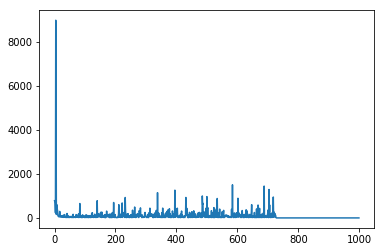

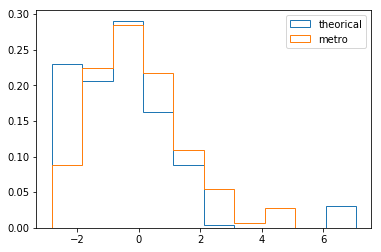

In [24]:
plt.plot(mean_sq_loss)
plt.show()
#bk = np.concatenate((np.array([K]), sp_l_i))
#l = np.power(lagrange_multipliers-bk,2)
#print(l)
n, bins, _  = plt.hist(sp_l_i, histtype = 'step', label = 'theorical', density = True)
plt.hist(lagrange_multipliers[1:], bins=bins, histtype = 'step', label = 'metro', density = True)

plt.legend()
plt.show()
#gradients = np.array(gradients[-100:]).flatten()
#plt.hist(gradients)
#plt.show()

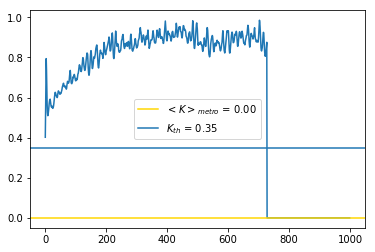

In [25]:
plt.plot(Ks)
plt.axhline(Ks[-100:].mean(), color = 'gold', label = r'$<K>_{metro}$'+' = %.2f'%Ks[-100:].mean())
plt.axhline(K, label = r'$K_{th}$'+' = %.2f'%K)
#plt.axhline(-K, color = 'red', label = r'$-K_{th}$'+' = %.2f'%-K)
plt.legend()
plt.show()

Note:
adam eta = 10^-3 10000 iterazioni la loss converge abbastanza, mentre k fa un po schifo
adam eta = 10^-4 10000 iterazioni loss fa cagare, k pure
adam eta = 0.1 1000 iterazioni abbastanza buoni entrambi (loss sotto i 100, k ondeggia)

### Phase diagram of the Hamiltonian

Consider as variables $K$, $\sigma = \sqrt{\frac{ \sum_{i=1}^S (\lambda_i - <\lambda>)^2}{S-1}}$ and $\beta = \frac{1}{T}$.

Defining $\hat{K} = \frac{K}{\sigma}$, $\hat{\lambda} = \beta \lambda$ and $\hat{\beta} = \sigma \beta$ one can show that for each $\hat{\beta}$ there is a $\hat{K}$ for which the Hamiltonian of section 4 is at a phase transition between the paramagnetic and the ferromagnetic phase. 

The equation of the curve of phase transition is 
$$2\hat{K} = \left(\int_{-\infty}^{+\infty}\frac{d\hat{\lambda}}{\sqrt{2\pi}} \frac{e^{(-\hat{\lambda}^2/2\hat{\beta}^2)}}{cosh(\hat{\lambda})^2} \right)^{-1}$$

In [17]:
import scipy.integrate as integrate

def f1(h, beta_hat):
    return 1/np.sqrt(2*np.pi)*np.exp(-0.5*h**2/beta_hat**2)/np.cosh(h)**2
    
def K_hat_beta_hat(beta_hat):
    I = integrate.quad(func = f1, a = -np.inf, b = np.inf, args = (beta_hat))[0]
    return 0.5/I

vec_K_hat = np.vectorize(K_hat_beta_hat)    

In [18]:
beta_hats = np.linspace(0.25, 1000, 10000)
K_hats =vec_K_hat(beta_hats)
T_hats = 1./beta_hats

/home/nicola/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in double_scalars
  after removing the cwd from sys.path.
/home/nicola/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in cosh
  after removing the cwd from sys.path.


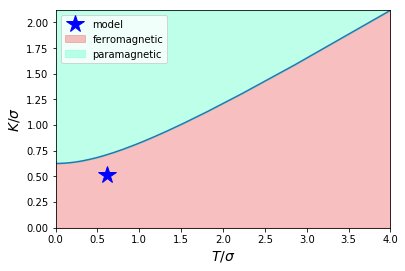

In [19]:
plt.plot(T_hats, K_hats)
ceiling = np.full(len(K_hats), K_hats.max())
plt.fill_between(T_hats, 0, K_hats, color = 'lightcoral' , alpha = 0.5, label = "ferromagnetic")
plt.fill_between(T_hats, K_hats, ceiling, color = 'aquamarine', alpha = 0.5, label = "paramagnetic")
plt.xlim(0,4)
plt.ylim(0,K_hats.max())

sigma = lagrange_multipliers[1:].std()
plt.plot(1/sigma, Ks[-10:].mean()/sigma, 'b*', markersize = 18, label = "model" )
plt.xlabel(r'$T/\sigma$', fontsize = 14)
plt.ylabel(r'$K/ \sigma$', fontsize = 14)
plt.legend()
plt.show()

In [56]:
help(plt.plot)

Help on function plot in module matplotlib.pyplot:

plot(*args, **kwargs)
    Plot y versus x as lines and/or markers.
    
    Call signatures::
    
        plot([x], y, [fmt], data=None, **kwargs)
        plot([x], y, [fmt], [x2], y2, [fmt2], ..., **kwargs)
    
    The coordinates of the points or line nodes are given by *x*, *y*.
    
    The optional parameter *fmt* is a convenient way for defining basic
    formatting like color, marker and linestyle. It's a shortcut string
    notation described in the *Notes* section below.
    
    >>> plot(x, y)        # plot x and y using default line style and color
    >>> plot(x, y, 'bo')  # plot x and y using blue circle markers
    >>> plot(y)           # plot y using x as index array 0..N-1
    >>> plot(y, 'r+')     # ditto, but with red plusses
    
    You can use `.Line2D` properties as keyword arguments for more
    control on the  appearance. Line properties and *fmt* can be mixed.
    The following two calls yield identical resu

In [47]:
#help(integrate.quad)
help(plt.fill_between)

Help on function fill_between in module matplotlib.pyplot:

fill_between(x, y1, y2=0, where=None, interpolate=False, step=None, hold=None, data=None, **kwargs)
    Fill the area between two horizontal curves.
    
    The curves are defined by the points (*x*, *y1*) and (*x*, *y2*). This
    creates one or multiple polygons describing the filled area.
    
    You may exclude some horizontal sections from filling using *where*.
    
    By default, the edges connect the given points directly. Use *step* if
    the filling should be a step function, i.e. constant in between *x*.
    
    
    Parameters
    ----------
    x : array (length N)
        The x coordinates of the nodes defining the curves.
    
    y1 : array (length N) or scalar
        The y coordinates of the nodes defining the first curve.
    
    y2 : array (length N) or scalar, optional, default: 0
        The y coordinates of the nodes defining the second curve.
    
    where : array of bool (length N), optional, de

## 6 - Max Ent 3

$ H = \sum_{i=1}^S \lambda_i x_i + \frac{1}{2}\sum_{i,j=1}^S M_{ij}x_i x_j$

$M_{ij}^{-1} = Cov(x_i,x_j)_{emp}$

$\lambda_i = - \sum_{j=1}^S M_{ij}x_j$

First of all we consider the matrix X of all the aboundances for all the subplots. It is a matrix of N rows and S columns.

In [28]:
X = cell_pop_M.reshape((200,299))

Then we compute for each species the mean and the standard deviation

In [29]:
x_mean = X.mean(axis = 0)
x_std = X.std(axis = 0)

We keep only those species that satisfy:

$<x_i>_{emp} - \sigma_{x_i} > 0$

In [30]:
aboundance_mask = x_mean - x_std > 0 
X_most_ab = X[:,aboundance_mask]

In this way we reduce the number of species from 299 to 52:

In [31]:
print(X_most_ab.shape[1])

52


Now we compute the inverse of the interaction matrix M as the covariance matrix of the abundances of the selected species and from that we obtain M inverting $M^{-1}$

In [32]:
inv_M = np.cov(X_most_ab.T)
M = np.linalg.inv(inv_M)

We now impose that the self interacting terms (diagonal) are null

In [33]:
mask = np.eye(M.shape[0]).astype('bool')
M[mask] = 0
print(M.trace())

0.0


In [34]:
print("Max interaction element: %.3f"%M.max())
print("Min interaction element: %.3f"%M.min())

Max interaction element: 0.176
Min interaction element: -0.093


At this point we can compute $\lambda_i$ with the formula reported at the begin of this section

In [35]:
X_most_mean = X_most_ab.mean(axis = 0)
lamb = -np.dot(M,X_most_mean)
#plt.hist(lamb)
#plt.show()
#plt.close()

# 7 - Analysis of the interaction network

In this first histogram we can see the distribuition of the entries of the matrix $M$. We can notice that the distribution is peaked around the zero (with a number of entries much higher than the length of the diagonal, i.e. ~600 vs 52) and it is more or less symmetric around zero.

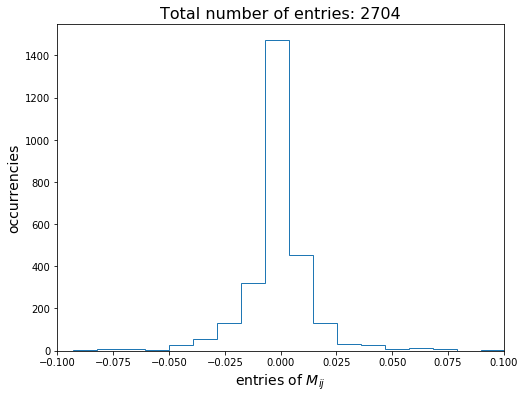

In [48]:
plt.figure(figsize = (8,6))
plt.hist(M.flatten(), bins = 25, histtype = 'step', density = False)
plt.xlim(-0.10, +0.10)
plt.xlabel("entries of $M_{ij}$", fontsize = 14)
plt.ylabel("occurrencies", fontsize = 14)
plt.title("Total number of entries: %d"%(len(M)**2), fontsize = 16)
plt.show()

Now we want to put a threshold $\theta$ on the absolute value of the entries of M. We choose as range for the threshold $[0,max(abs(M))]$

In [37]:
def laplacian(A):
    degrees = A.sum(axis = 0)
    K = np.diag(degrees)
    return K-A

In [38]:
# number of threshold we want to use
T = 2000
# consider evenly spaced thresholds
thresholds = np.linspace(0, np.max(np.abs(M)), T)
# placehholder for the number of connected components for each threshold
connected_components = np.zeros(T)
# this is the order of magnitude under which we consider zero an eigenvalue
sensibility = 10**-12 
#OBS: it can't be taken too small otherwise it would count 0 connected components for theta = 0, that is absurd

for i,theta in enumerate(thresholds):
    # elementwise boolean operation, returns a matrix of True and False
    threshold_mask = np.abs(M) > theta 
    # we can compute directly the adjacency matrix from the threshold mask
    A = threshold_mask.astype(int)
    # compute the laplacian of A
    L = laplacian(A)
    # eigenvalue decomposition; "eigh" used for symmetric matrix -> default format fo eigenvalues is set to float
    eig_values,V = np.linalg.eigh(L)
    # we take as zero all the eigenvalues with absolute value under the chosen sensibility 
    almost_zero = np.abs(eig_values) < sensibility
    # number of conncected components = number of zero eigenvalues (or equivalently degeneracy of eigval 0)
    connected_components[i] = np.count_nonzero(almost_zero.astype(int))

In [52]:
one_component_mask = connected_components == 1
theta_star = np.max(thresholds[one_component_mask])
print("Estimated theta star: %.4f"%theta_star)

Estimated theta star: 0.0031


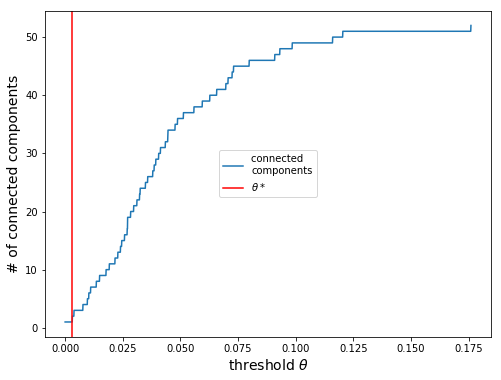

In [59]:
plt.figure(figsize = (8,6))
plt.plot(thresholds, connected_components, label = 'connected \ncomponents')
plt.xlabel("threshold "+r"$\theta$", fontsize = 14)
plt.ylabel("# of connected components", fontsize = 14)
plt.axvline(theta_star, color = 'red', label = r'$\theta*$')
plt.legend(loc = 'center')
plt.show()

In [41]:
# if we are interested in the detailed correspondence between threshold and connected components
for t,c in zip(thresholds, connected_components):
    print("Threshold = %.4f, connected components = %.d"%(t,c))

Threshold = 0.0000, connected components = 1
Threshold = 0.0001, connected components = 1
Threshold = 0.0002, connected components = 1
Threshold = 0.0003, connected components = 1
Threshold = 0.0004, connected components = 1
Threshold = 0.0004, connected components = 1
Threshold = 0.0005, connected components = 1
Threshold = 0.0006, connected components = 1
Threshold = 0.0007, connected components = 1
Threshold = 0.0008, connected components = 1
Threshold = 0.0009, connected components = 1
Threshold = 0.0010, connected components = 1
Threshold = 0.0011, connected components = 1
Threshold = 0.0011, connected components = 1
Threshold = 0.0012, connected components = 1
Threshold = 0.0013, connected components = 1
Threshold = 0.0014, connected components = 1
Threshold = 0.0015, connected components = 1
Threshold = 0.0016, connected components = 1
Threshold = 0.0017, connected components = 1
Threshold = 0.0018, connected components = 1
Threshold = 0.0018, connected components = 1
Threshold 

Threshold = 0.1480, connected components = 51
Threshold = 0.1481, connected components = 51
Threshold = 0.1482, connected components = 51
Threshold = 0.1483, connected components = 51
Threshold = 0.1483, connected components = 51
Threshold = 0.1484, connected components = 51
Threshold = 0.1485, connected components = 51
Threshold = 0.1486, connected components = 51
Threshold = 0.1487, connected components = 51
Threshold = 0.1488, connected components = 51
Threshold = 0.1489, connected components = 51
Threshold = 0.1490, connected components = 51
Threshold = 0.1491, connected components = 51
Threshold = 0.1491, connected components = 51
Threshold = 0.1492, connected components = 51
Threshold = 0.1493, connected components = 51
Threshold = 0.1494, connected components = 51
Threshold = 0.1495, connected components = 51
Threshold = 0.1496, connected components = 51
Threshold = 0.1497, connected components = 51
Threshold = 0.1498, connected components = 51
Threshold = 0.1498, connected comp

In [42]:
import networkx as nx

In [43]:
threshold_mask = np.abs(M) > theta_star
# this is the adjacency matrix that we are going to use for our analysis
A_star = threshold_mask.astype(int)

Analyze the structural properties of W * (degree distribution, diameter, clustering, degree assortativity, betweeness centrality). In what respect, if any, the graph is different from a random ER graph?

Mean degree: 30.42
Degree standard deviation: 10.28


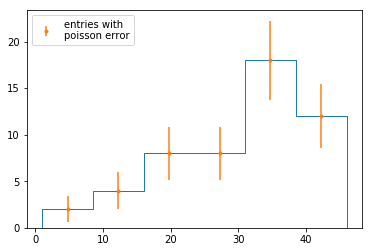

In [44]:
K = A_star.sum(axis = 0)
print("Mean degree: %.2f"% K.mean())
print("Degree standard deviation: %.2f"% K.std())
# not having much elements for a graphs we prefer to use a small amount of bins 
# in order to capture less information but more reliable
entries, bin_extremes, _ = plt.hist(K, bins = 6, histtype = 'step')
bin_centers = (bin_extremes[1:] + bin_extremes[:-1])/2
plt.errorbar(bin_centers, entries, yerr = np.sqrt(entries), fmt = '.', label = 'entries with \npoisson error')
plt.legend(loc = "upper left")
plt.show()

Using the networkx library we can easily compute most of the quantities of interest.

In [45]:
G = nx.from_numpy_matrix(A_star)

D = nx.diameter(G)
print("Diameter of the network: ", D)

# local clustering for each node
c_i_dict = nx.clustering(G)
n_nodes = len(G)
c_i = np.zeros(n_nodes)
for i in range(n_nodes):
    c_i[i] = c_i_dict[i]
    
# global clustering
C = c_i.mean()
print("Global clustering coefficient: %.2f"% C)

deg_assortativity = nx.degree_assortativity_coefficient(G)
print("Degree assortativity: %.2f"%deg_assortativity)

btw_centrality = nx.betweenness_centrality(G)
b_c = np.zeros(n_nodes)
for i in range(n_nodes):
    b_c[i] = btw_centrality[i]
print("Max beetweenness centrality: %.2f"%b_c.max())

Diameter of the network:  3
Global clustering coefficient: 0.73
Degree assortativity: -0.24
Max beetweenness centrality: 0.05


We can compare these results with the one that we would find in an Erdosh-Reny graph with the same number of nodes and with probability of connecting two nodes given by $p = \frac{<k>}{n-1}$, where $<k>$ is the observed average degree of $A^*$. To do this, we consider an ensamble of E-R graphs in order to compute the estimated quantities and not the one of a single realization.

In [46]:
p = K.mean()/(n_nodes-1)
graphs_number = 100

# we are going to store in the following arrays all the results for each single ER graph 
# and then make a statistic out of them
ER_k_std_devs = np.zeros(graphs_number)
ER_diameters = np.zeros(graphs_number)
ER_cluster_coeffs = np.zeros(graphs_number)
ER_deg_assortativities = np.zeros(graphs_number)
ER_max_btw_centralities = np.zeros(graphs_number)


for i in range(graphs_number):
    # create an Erdosh-Reny graph
    ERG = nx.gnp_random_graph(n_nodes,p)
    # compute the degree standard deviation
    degs_dict = ERG.degree()
    degs = np.zeros(n_nodes)
    for j in range(n_nodes):
        degs[j] = degs_dict[j]
    ER_k_std_devs[i] = degs.std()
    
    ER_diameters[i] =  nx.diameter(ERG)
    
    c_i_dict = nx.clustering(ERG)
    c_i = np.zeros(n_nodes)
    for j in range(n_nodes):
        c_i[j] = c_i_dict[j]

    # global clustering
    ER_cluster_coeffs[i] = c_i.mean()

    ER_deg_assortativities[i] = nx.degree_assortativity_coefficient(ERG)

    btw_centrality = nx.betweenness_centrality(ERG)
    b_c = np.zeros(n_nodes)
    for j in range(n_nodes):
        b_c[j] = btw_centrality[j]
    ER_max_btw_centralities[i] = b_c.max()

print("Degree standard deviation: %.2f"% ER_k_std_devs.mean())
print("Diameter of the network: %.2f" % ER_diameters.mean())
print("Global clustering coefficient: %.2f"% ER_cluster_coeffs.mean())
print("Degree assortativity: %.2f"%ER_deg_assortativities.mean())
print("Max beetweenness centrality: %.2f"%ER_max_btw_centralities.mean())

Degree standard deviation: 3.37
Diameter of the network: 2.00
Global clustering coefficient: 0.60
Degree assortativity: -0.04
Max beetweenness centrality: 0.01


Confronting the results of the real network with the ensamble of ER graphs:

| Quantity | Real graph | ER graph|
| --- | --- | --- |
| degree std dev | 10.28 | 3.38 |
| diameter | 3 | 2.00 |
| clustering | 0.73| 0.59 |
| assortativity | -0.24 | -0.04 |
| max centrality | 0.05 | 0.01 |

We can see that none of these quantities is too similar between the two kinds of graphs. 

More precisely we can conclude that our network:
* presents a much higher variance in the degree distribution;
* has a larger diameter (ER diameter being 2.00 for a hundred graphs imply that none of them has diameter equal 3!);
* has a higher clustering coefficient;
* has a disassortative behaviour w.r.t. the almost neutral one of the ER ensamble;
* has a central node with a betweenness centrality that is 5 times higher than the "central" node of ER graphs.

All this suggests that the network of the species has an underlying structure that is not random, but possibly depends on the "microscopic" details of each species.

NOTE: ER results could vary a bit because we don't have a fixed seed for their generator.